# Fema French Model
1. Market Factor - Excess market return
2. Size Factor (SMB) - Excess return with small market cap over those large market cap
3. Value Factor (HML) - Excess return of value stocks over growth stocks

$$r = R_f+\beta(R_m - R_f) + b_s * SMB + b_v * HML + \alpha$$

## Portfolio construction
The Fama/French factors are constructed using the 6 value-weight portfolios formed on size and book-to-market<br/>
SMB are divided into 2 segments based on median of market cap among all stocks (i.e. Small/Big)<br/>
HML are divided into 3 segments based on 30%/70% quantiles among all stocks (i.e. Value/Neutral/Growth)<br/>
Therefore, we will create 6 portfolios, the factor return are then calculated as below

- SMB - Average return on the three small portfolios minus the average return on the three big portfolios,

$$1/3 * (\text{Small Value} + \text{Small Neutral} + \text{Small Growth}) - 1/3 * (\text{Big Value} + \text{Big Neutral} + \text{Big Growth})$$

- HML is the average return on the two value portfolios minus the average return on the two growth portfolios
$$HML = 1/2 * (\text{Small Value} + \text{Big Value}) - 1/2 * (\text{Small Growth} + \text{Big Growth})$$

## How to constrcut our portfolios?
It is impossible for retail traders to construct exactly the same Fema Fench portfolios, but with the help of the factor models, we can minic the portfolios with less number of stocks. We just need to make sure the portfolios has SMB or HML exposure of 1 respectively, that your portfolio should be theoretically same as the original Fema French Model
- e.g. i want to minic the SMB portfolios, i just need a portfolios with $\hat b_s = 1$ and $\hat\beta = 0$
- e.g. i want to minic the SMB and HML portfolios, i just need a portfolios with $\hat b_s = \hat b_v = 1$ and $\hat\beta = 0$

In [105]:
import pandas as pd
import yfinance as yf
import statsmodels.api as sm
import getFamaFrenchFactors as gff
import numpy as np
import warnings
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from functools import cache
from Utils import *
from tqdm import tqdm
from datetime import datetime, date

warnings.filterwarnings('ignore')
pd.options.display.float_format = '{:,.4f}'.format

### Fetch FF3 factors data via API (only monthly and anuual data is available)
Official data source is https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/data_library.html

In [2]:
ticker = 'MSFT'
start = '2016-8-31'
end = '2023-8-31'

df = yf.download(tickers=ticker,start=start, end=end, interval="1d",auto_adjust=True)

ff3_monthly = gff.famaFrench3Factor(frequency='m')
ff3_monthly.rename(columns={"date_ff_factors": 'Date'}, inplace=True)
ff3_monthly.set_index('Date', inplace=True)

df_chg = df.resample('M').last().pct_change().dropna()
ff3_monthly = pd.merge(ff3_monthly, df_chg, on='Date', how='inner', validate='1:1')

[*********************100%***********************]  1 of 1 completed


### Use linear regression to fit the model to find $\beta, b_s, b_v$
$$r - R_f = \hat\beta(R_m - R_f) + \hat b_s * SMB + \hat b_v * HML + \alpha + \epsilon$$

1. If p values < 0.05, liekly that the factor is less significant in explain the stock prices
2. market factor < 1 implies the stock is less volatile than the market

In [3]:
X = ff3_monthly[['Mkt-RF', 'SMB', 'HML']]
y = ff3_monthly['Close'] - ff3_monthly['RF']
X = sm.add_constant(X)
ff_model = sm.OLS(y, X).fit()
intercept, b1, b2, b3 = ff_model.params
intercept_p, b1_p, b2_p, b3_p = ff_model.pvalues

print(ff_model.summary())
print()
print('1. Market Factor:      {:.3f} (p={:.3f})'.format(b1, b1_p))
print('2. Size Factor (SMB):  {:.3f} (p={:.3f})'.format(b2, b2_p))
print('3. Value Factor (HML): {:.3f} (p={:.3f})'.format(b3, b3_p))

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.712
Model:                            OLS   Adj. R-squared:                  0.701
Method:                 Least Squares   F-statistic:                     64.20
Date:                Wed, 23 Aug 2023   Prob (F-statistic):           5.15e-21
Time:                        01:53:53   Log-Likelihood:                 169.18
No. Observations:                  82   AIC:                            -330.4
Df Residuals:                      78   BIC:                            -320.7
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0125      0.004      3.490      0.0

In [4]:
rf = ff3_monthly['RF'].mean()
market_premium = ff3_monthly['Mkt-RF'].mean()
size_premium = ff3_monthly['SMB'].mean()
value_premium = ff3_monthly['HML'].mean()

expected_monthly_return = rf + b1 * market_premium + b2 * size_premium + b3 * value_premium 
expected_yearly_return = expected_monthly_return * 12
print("Expected yearly return: " + str(expected_yearly_return))

Expected yearly return: 0.14687956928532625


### Read from daily factors sheets from official sources and rerun linear regression

In [5]:
@cache
def get_daily_ff3_factors():
    url = 'https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/ftp/F-F_Research_Data_Factors_daily_CSV.zip'
    ff3 = pd.read_csv(url, compression='zip', skiprows=3, skipfooter=1, engine='python')
    ff3 = ff3.rename(columns={'Unnamed: 0': 'Date'})
    ff3['Date'] = pd.to_datetime(ff3['Date'], format='%Y%m%d')
    ff3['Mkt-RF'] /= 100
    ff3['SMB'] /= 100
    ff3['HML'] /= 100
    ff3['RF'] /= 100    
    return ff3

df = yf.download(tickers=ticker,start=start, end=end, interval="1d",auto_adjust=True)
df['return'] = df['Close'].pct_change().fillna(0)
ff3 = get_daily_ff3_factors()
ff3 = pd.merge(ff3, df, on='Date', how='inner', validate='1:1')

X = ff3[['Mkt-RF', 'SMB', 'HML']]
y = ff3['return'] - ff3['RF']
X = sm.add_constant(X)
ff_model = sm.OLS(y, X).fit()
intercept, b1, b2, b3 = ff_model.params
intercept_p, b1_p, b2_p, b3_p = ff_model.pvalues

print(ff_model.summary())
print()
print('1. Market Factor:      {:.3f} (p={:.3f})'.format(b1, b1_p))
print('2. Size Factor (SMB):  {:.3f} (p={:.3f})'.format(b2, b2_p))
print('3. Value Factor (HML): {:.3f} (p={:.3f})'.format(b3, b3_p))


[*********************100%***********************]  1 of 1 completed
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.773
Model:                            OLS   Adj. R-squared:                  0.772
Method:                 Least Squares   F-statistic:                     1942.
Date:                Wed, 23 Aug 2023   Prob (F-statistic):               0.00
Time:                        01:53:55   Log-Likelihood:                 5746.7
No. Observations:                1719   AIC:                        -1.149e+04
Df Residuals:                    1715   BIC:                        -1.146e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------

# Calculate FF3 Factors for all SP500 stocks

In [6]:
tickers = get_sp500_tickers()
raw = yf.download(tickers=tickers,period="2y",interval="1d",auto_adjust=True).reset_index()

[*********************100%***********************]  503 of 503 completed


In [7]:
ff3 = get_daily_ff3_returns()
# there is a stock called RF
ff3 = ff3.rename(columns={'RF':'RFree'})
df = raw.copy()
df = df[['Date','Close']]
df['Close'] = df['Close'].pct_change().fillna(0)
df = df.droplevel(0, axis=1)
df = df.rename(columns={'': 'Date'})
df = pd.merge(df, ff3, how='inner', on='Date', validate='1:1')

In [8]:
ff3_factors_arr = []

with tqdm(total=len(tickers)) as pbar:
    for ticker in tickers:    
        X = df[['Mkt-RF', 'SMB', 'HML']]
        X = sm.add_constant(X)
        y = df[ticker] - df['RFree']
        
        ff_model = sm.OLS(y, X).fit()
        intercept, b1, b2, b3 = ff_model.params
        intercept_p, b1_p, b2_p, b3_p = ff_model.pvalues
        row = {
            'ticker': ticker,
            'f_mkt': b1,
            'f_smb': b2,
            'f_hml': b3,
            'f_const': intercept,
            'p_mkt': b1_p,
            'p_smb': b2_p,
            'p_hml': b3_p,
            'p_const': intercept_p,
            'is_mkt_f_true': b1_p < 0.05,
            'is_smb_f_true': b2_p < 0.05,
            'is_hml_f_true': b3_p < 0.05,
            'is_const_f_true': intercept_p < 0.05,
        }
        ff3_factors_arr.append(row)
        pbar.update(1)

ff3_factors = pd.DataFrame(ff3_factors_arr)

100%|██████████| 503/503 [00:00<00:00, 1256.45it/s]


## Check the YTD factor performance based on factor sheet

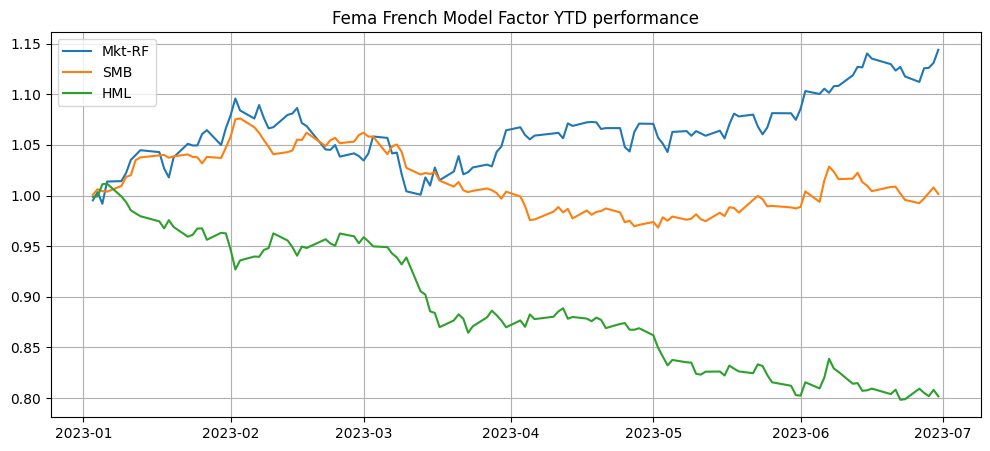

In [9]:
ff3 = get_daily_ff3_returns()
ff3 = ff3[ff3['Date'] > datetime(year=datetime.today().year, month=1, day=1)]
ff3['Mkt-RF'] = (1+ff3['Mkt-RF']).cumprod()
ff3['SMB'] = (1+ff3['SMB']).cumprod()
ff3['HML'] = (1+ff3['HML']).cumprod()
ff3['RF'] = (1+ff3['RF']).cumprod()

plt.figure(figsize=(12,5))
plt.plot(ff3['Date'], ff3['Mkt-RF'], label='Mkt-RF')
plt.plot(ff3['Date'], ff3['SMB'], label='SMB')
plt.plot(ff3['Date'], ff3['HML'], label='HML')
plt.legend()
plt.title('Fema French Model Factor YTD performance')
plt.grid()
plt.show()

# Use Fema French Model to constrcut a portfolios
- Portfolios to be rebalanced monthly, so we calculate the expected returns in a monthly basis
- We only consider portfolios where the factor has a pvalue < 0.05, this should reduce assets by around half of the assetu universes

1. Extract the ff3 returns and calculate the average monthly ff3 returns in last 80 BDays 
2. Based on factor exposure, calculate the expected returns
3. Optimize the portfolios 

- cp.Norm() = $\sum_i |x_i|$ this controls maximum of leverage

In [172]:
from pandas.tseries.offsets import BDay
import cvxpy as cp
import scipy.stats as stats

In [17]:
ff3 = get_daily_ff3_returns()
ff3 = ff3[ff3['Date'] >= datetime.today() - BDay(80)]
mkt_rf = ((1 + ff3['Mkt-RF']).prod() - 1) / len(ff3) * 21
smb = ((1 + ff3['SMB']).prod() - 1) / len(ff3) * 21
hml = ((1 + ff3['HML']).prod() - 1) / len(ff3) * 21
rf = ((1 + ff3['RF']).prod() - 1) / len(ff3) * 21

df_p = ff3_factors.copy()
df_p = df_p[df_p['is_mkt_f_true'] == True]
df_p = df_p[df_p['is_smb_f_true'] == True]
df_p = df_p[df_p['is_hml_f_true'] == True]
print("# of names remainings: {}".format(len(df_p)))

df_p['mkt_rf'] = mkt_rf
df_p['smb'] = smb
df_p['hml'] = hml
df_p['rf'] = rf
df_p['expected_return'] = \
    df_p['rf'] + \
    df_p['f_mkt'] * df_p['mkt_rf'] + \
    df_p['f_smb'] * df_p['smb'] + \
    df_p['f_hml'] * df_p['hml']

# of names remainings: 232


In [71]:
tickers = list(df_p['ticker'].values)
df_return = df.copy()
df_return = df_return[['Date'] + tickers]                
df_return = df_return.set_index('Date')
daily_returns = df_return.values

monthly_returns_cov = np.cov(daily_returns.T * 21)
monthly_expected_returns = df_p['expected_return'].values

In [187]:
w = cp.Variable(len(tickers))
gamma = cp.Parameter(nonneg=True)
ret = monthly_expected_returns.T @ w
risk = cp.quad_form(w, monthly_returns_cov)
constraints = [
    cp.sum(w) == 1,     # uses all cash
    w >= 0,             # long only
    #cp.norm(w,1) <= 2   # max leverage limit
]
prob = cp.Problem(cp.Maximize(ret - gamma * risk), constraints)
gamma_vals = np.logspace(-2, 3, num=100)
risk_data = []
ret_data = []
ws = []

for g in gamma_vals:
    gamma.value = g
    prob.solve()
    risk_data.append(cp.sqrt(risk).value)
    ret_data.append(ret.value)
    ws.append(w.value)

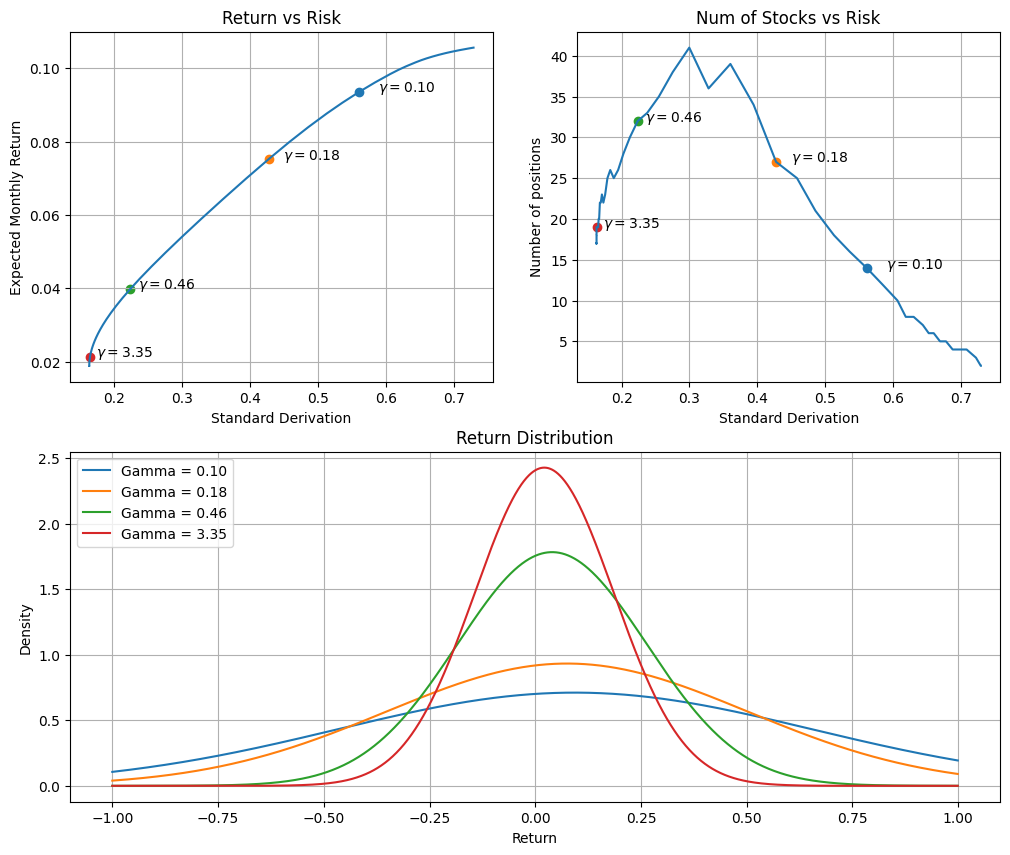

In [188]:
num_pos = [len(w[abs(w) > 0.01]) for w in ws]
gamma_markers_on = [len(gamma_vals)//5, len(gamma_vals)//4, len(gamma_vals)//3, len(gamma_vals)//2]

fig = plt.figure(figsize=(12,10))
gs = GridSpec(2,2)

ax = fig.add_subplot(gs[0,0])
ax.plot(risk_data, ret_data)
for i in gamma_markers_on:
    xx, yy = float(risk_data[i]), float(ret_data[i])
    ax.scatter(xx, yy)
    ax.annotate(r"$\gamma = %.2f$" % gamma_vals[i], xy=(xx + xx/20, yy))

ax.set_ylabel("Expected Monthly Return")
ax.set_xlabel("Standard Derivation")
ax.set_title("Return vs Risk")
ax.grid()

ax = fig.add_subplot(gs[0,1])
ax.plot(risk_data, num_pos)
for i in gamma_markers_on:
    xx, yy = float(risk_data[i]), float(num_pos[i])
    ax.scatter(xx, yy)
    ax.annotate(r"$\gamma = %.2f$" % gamma_vals[i], xy=(xx + xx/20, yy))
ax.set_ylabel("Number of positions")
ax.set_xlabel("Standard Derivation")
ax.set_title("Num of Stocks vs Risk")
ax.grid()

ax = fig.add_subplot(gs[1,:])
for i in gamma_markers_on:    
    x = np.arange(-1,1,0.001)
    ret = ret_data[i]
    risk = risk_data[i]
    ax.plot(x, stats.norm.pdf(x, ret, risk), label='Gamma = {:.2f}'.format(gamma_vals[i]))

ax.set_title("Return Distribution")
ax.set_ylabel("Density")
ax.set_xlabel("Return")
ax.legend(loc = 'upper left')
ax.grid()
